In [1]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
import os 
from statsmodels.stats import multitest

statspath = '/Users/nicolasfarrugia/Documents/recherche/git/pd_osc_decoding/alldata_proba/'

Step 0 - preparing data 

fields for the saved stats files are : 
- scores
- proba
- pval
- U

For each of them, layout is 4 (Regreg,RegIrreg,IrregReg,IrregIrreg) x CV x TestTime x TrainTime

In [2]:
allsubj = os.listdir(statspath)

In [3]:
allsubj

['180523_01c1_formal_conditionwise.npz',
 '180523_01k1_formal_conditionwise.npz',
 '180523_01m1_formal_conditionwise.npz',
 '180523_02c1_formal_conditionwise.npz',
 '180523_02k1_formal_conditionwise.npz',
 '180523_02m1_formal_conditionwise.npz',
 '180523_03c1_formal_conditionwise.npz',
 '180523_03k1_formal_conditionwise.npz',
 '180523_03m1_formal_conditionwise.npz',
 '180523_04c1_formal_conditionwise.npz',
 '180523_04k1_formal_conditionwise.npz',
 '180523_04m1_formal_conditionwise.npz',
 '180523_05c1_formal_conditionwise.npz',
 '180523_05k1_formal_conditionwise.npz',
 '180523_06c1_formal_conditionwise.npz',
 '180523_06k1_formal_conditionwise.npz',
 '180523_07c1_formal_conditionwise.npz',
 '180523_07k1_formal_conditionwise.npz',
 '180523_08c1_formal_conditionwise.npz',
 '180523_08k1_formal_conditionwise.npz',
 '180523_09c1_formal_conditionwise.npz',
 '180523_09k1_formal_conditionwise.npz',
 '180523_10c1_formal_conditionwise.npz',
 '180523_10k1_formal_conditionwise.npz',
 '180523_11c1_fo

Group files per subject type (patients or control) 

In [4]:
controls_id = []
patients_id = []

for cursubj in allsubj:
    if (cursubj[9]=='k'):
        controls_id.append(cursubj)
    else:
        patients_id.append(cursubj)
            

Step 1 - Analysis of "Diagonal" Classification

We average the diagonal of the p values of the within-subjects Mann Whittney U-Test, and average them across CV folds. We correct the resulting p values using FDR Benjamin Hochberg correction, and sum the resulting vectors across all subjects. 

We also compute an uncorrected version with a threshold of $p < 0.01$

In [89]:
tmin = -0.05
tmax = 0.52

timevec = np.linspace(tmin,tmax,diag_sig_fdr_controls.shape[1])

In [134]:
def diagonal_group(subjlist,statspath,thresh_unc = 0.01,timevec=timevec,showall=False,threshold_zeros=40,doplots=True):


    if (showall):
        print("Showing all subjects")
    else:
        print("Showing subjects with less than %d FDR significant points" % threshold_zeros)
    
    diag_sig_fdr_all = []
    diag_sig_unc_all = []
    diag_ROC_all = []
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curroc = np.load(cursubj)['scores'].mean(axis=1)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([np.diag(curmat) for curmat in curpvals]) # extract diagonal classification

        diag_ROC = np.stack([np.diag(curmat) for curmat in curroc]) # extract diagonal classification
        diag_ROC_all.append(diag_ROC)
        
        diag_sig_fdr = []
        diag_sig_unc = []
        for curdiag in diag_pvals:
            H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
            H_unc = curdiag < thresh_unc
            diag_sig_unc.append(H_unc)
            diag_sig_fdr.append(H)

        nonzeros = np.sum(np.stack(diag_sig_fdr))
        if showall:
            print("Subj %s number of non-zeros FDR : %d " %(subj,nonzeros))
        elif nonzeros < threshold_zeros:
            print("Subj %s has zero or few significant FDR : %d " %(subj,nonzeros))
            
            if (nonzeros >= 0 ) and doplots:
                #plt.subplot(1,2,1)
                plt.plot(timevec,diag_sig_fdr[0])
                #plt.subplot(1,2,2)
                plt.plot(timevec,diag_ROC[0])
                plt.show()
            
        
        #print("Subj %s number of non-zeros Uncorrected : %d " %(subj,np.sum(np.stack(diag_sig_unc))))
        
        diag_sig_fdr_all.append(np.stack(diag_sig_fdr))
        diag_sig_unc_all.append(np.stack(diag_sig_unc))
        
    
    return np.sum(np.stack(diag_sig_fdr_all),axis=0),np.sum(np.stack(diag_sig_unc_all),axis=0),np.stack(diag_ROC_all)

In [135]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False)

Showing subjects with less than 40 FDR significant points
Subj 180523_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180523_07k1_formal_conditionwise.npz has zero or few significant FDR : 4 
Subj 180523_11k1_formal_conditionwise.npz has zero or few significant FDR : 13 
Subj 180523_17k1_formal_conditionwise.npz has zero or few significant FDR : 4 
Subj 180523_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Showing subjects with less than 40 FDR significant points
Subj 180523_01m1_formal_conditionwise.npz has zero or few significant FDR : 24 
Subj 180523_04c1_formal_conditionwise.npz has zero or few significant FDR : 1 
Subj 180523_04m1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180523_08c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180523_09c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180523_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180523_1

5 controls and 11 patients don't have enough decodable information in "diagonal decoding", which informally means that when training a classifier to discriminate between standard and deviants, at one specific time point (=thus "diagonal" decoding), the estimated probabilities of each trial being classified as either a standard or a deviant cannot be reliably distinguished (as shown by a lack of significance in a Mann-Whitney U-test). 

We can examine the ROC AUC scores for the same subjects, to check whether this phenomenon has anything to do with classification performance (it should!). For that, we overlay the FDR-corrected timewise significance of the Mann-Whitney U-test with the ROC AUC performance of the problematic subjects

Showing subjects with less than 40 FDR significant points
Subj 180523_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 


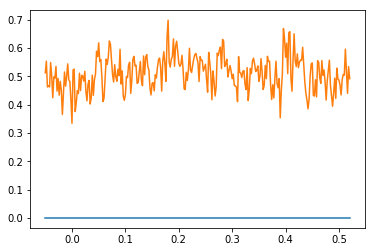

Subj 180523_07k1_formal_conditionwise.npz has zero or few significant FDR : 4 


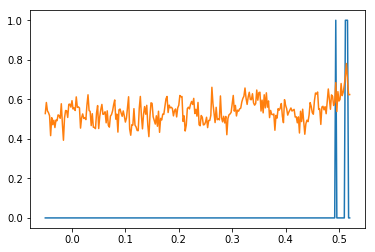

Subj 180523_11k1_formal_conditionwise.npz has zero or few significant FDR : 13 


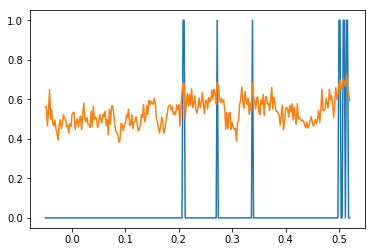

Subj 180523_17k1_formal_conditionwise.npz has zero or few significant FDR : 4 


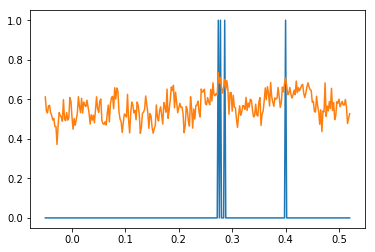

Subj 180523_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 


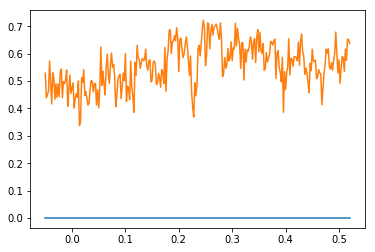

Showing subjects with less than 40 FDR significant points
Subj 180523_01m1_formal_conditionwise.npz has zero or few significant FDR : 24 


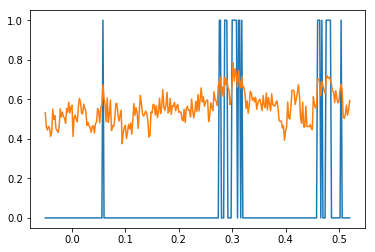

Subj 180523_04c1_formal_conditionwise.npz has zero or few significant FDR : 1 


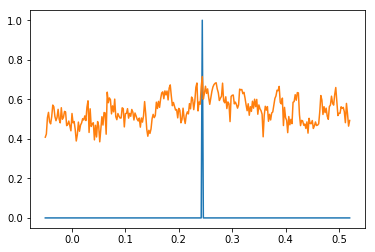

Subj 180523_04m1_formal_conditionwise.npz has zero or few significant FDR : 0 


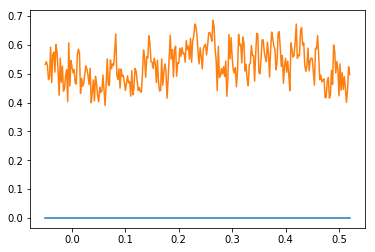

Subj 180523_08c1_formal_conditionwise.npz has zero or few significant FDR : 0 


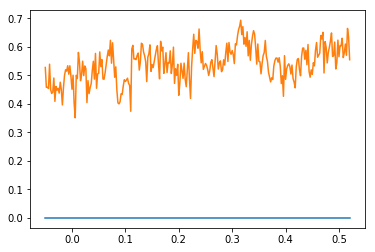

Subj 180523_09c1_formal_conditionwise.npz has zero or few significant FDR : 0 


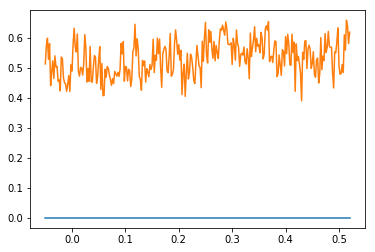

Subj 180523_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 


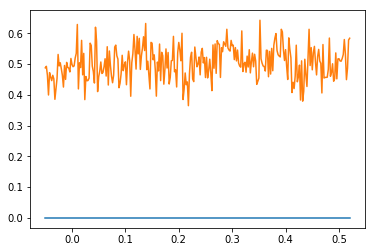

Subj 180523_12c1_formal_conditionwise.npz has zero or few significant FDR : 8 


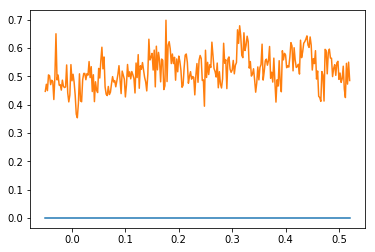

Subj 180523_13c1_formal_conditionwise.npz has zero or few significant FDR : 12 


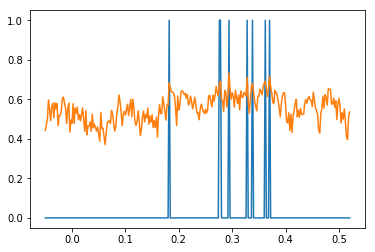

Subj 180523_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 


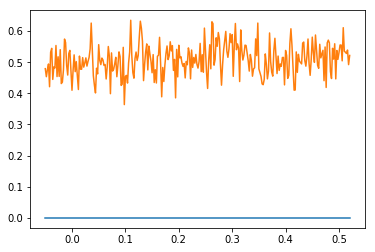

Subj 180523_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 


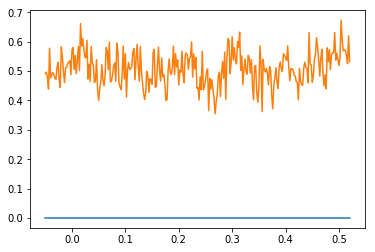

Subj 180523_17c1_formal_conditionwise.npz has zero or few significant FDR : 1 


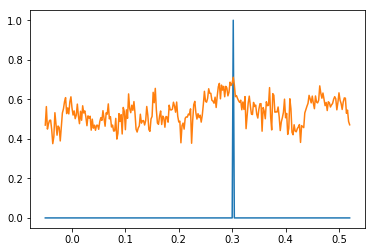

In [136]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=True)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=True)

Create the time vector and titles for the plots 

In [13]:
tmin = -0.05
tmax = 0.52

timevec = np.linspace(tmin,tmax,diag_sig_fdr_controls.shape[1])


subtitles = ['Train Regular Test Regular',
            'Train Regular Test Irregular',
            'Train Irregular Test Regular',
            'Train Irregular Test Irregular']


In [114]:
def four_plots(timevec,subtitles,diag_sig,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,diag_sig[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Diagonal decoding - %s - FDR-corrected' % mytitle)
    plt.show()

In [123]:
def four_errorplots(timevec,subtitles,diag_roc,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.errorbar(timevec,diag_roc[:,i-1,:].mean(axis=0),yerr=diag_roc[:,i-1,:].std(axis=0),errorevery=5)
        plt.title(subtitles[i-1])
    plt.suptitle('Diagonal decoding - %s - FDR-corrected' % mytitle)
    plt.show()

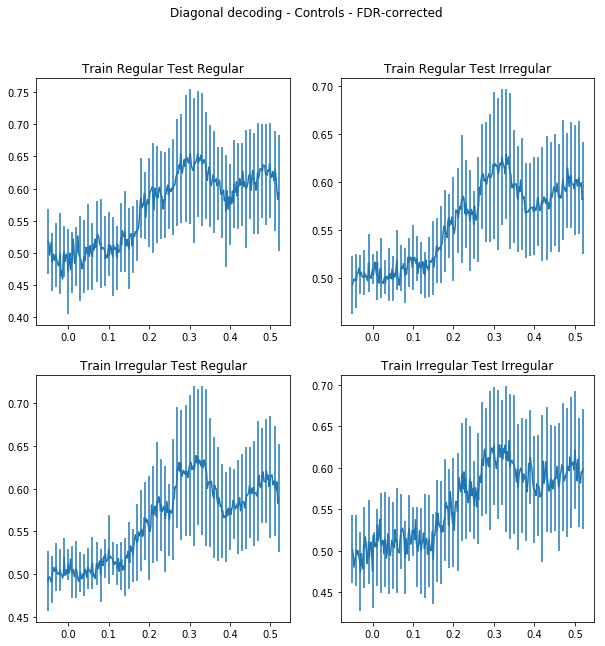

In [125]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls')

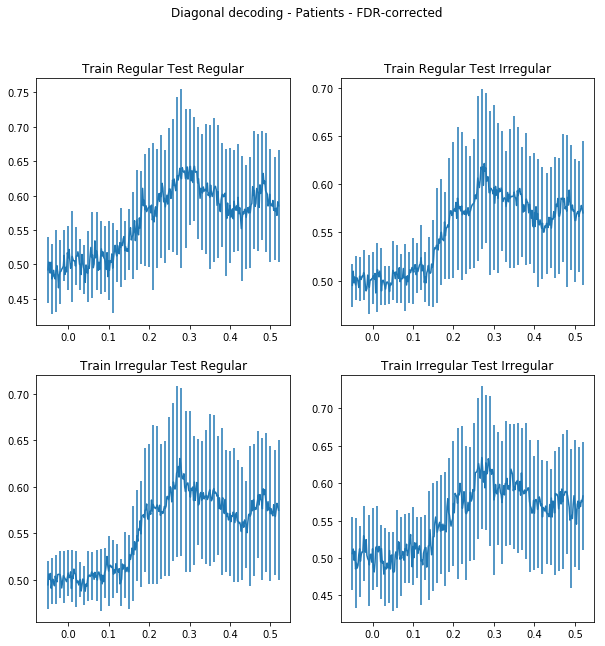

In [126]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients')

Output number of FDR corrected Mann Whitney whithin subjects statistics for all subjects 

In [104]:
diag_sig_fdr_controls,diag_sig_unc_controls = diagonal_group(controls_id,statspath,0.05,showall=True)
diag_sig_fdr_patients,diag_sig_unc_patients = diagonal_group(patients_id,statspath,0.05,showall=True)

Showing all subjects
Subj 180523_01k1_formal_conditionwise.npz number of non-zeros FDR : 274 
Subj 180523_02k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 180523_03k1_formal_conditionwise.npz number of non-zeros FDR : 178 
Subj 180523_04k1_formal_conditionwise.npz number of non-zeros FDR : 129 
Subj 180523_05k1_formal_conditionwise.npz number of non-zeros FDR : 198 
Subj 180523_06k1_formal_conditionwise.npz number of non-zeros FDR : 48 
Subj 180523_07k1_formal_conditionwise.npz number of non-zeros FDR : 4 
Subj 180523_08k1_formal_conditionwise.npz number of non-zeros FDR : 245 
Subj 180523_09k1_formal_conditionwise.npz number of non-zeros FDR : 78 
Subj 180523_10k1_formal_conditionwise.npz number of non-zeros FDR : 135 
Subj 180523_11k1_formal_conditionwise.npz number of non-zeros FDR : 13 
Subj 180523_12k1_formal_conditionwise.npz number of non-zeros FDR : 123 
Subj 180523_13k1_formal_conditionwise.npz number of non-zeros FDR : 428 
Subj 180523_14k1_formal_conditionwise

FDR plots

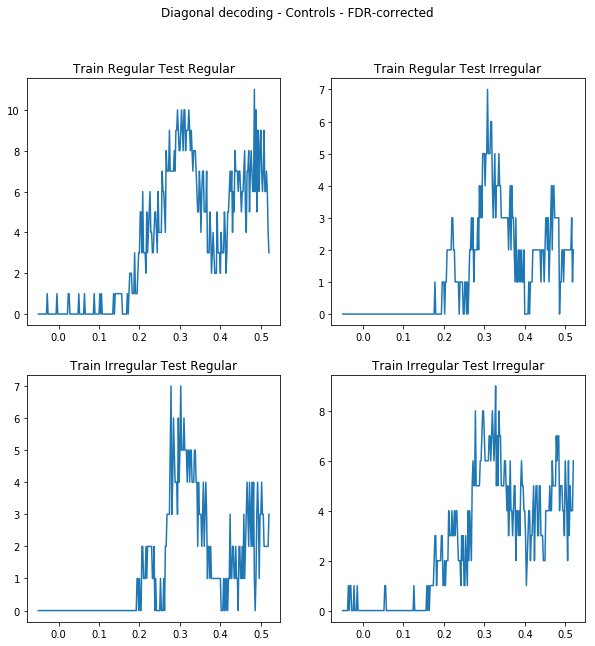

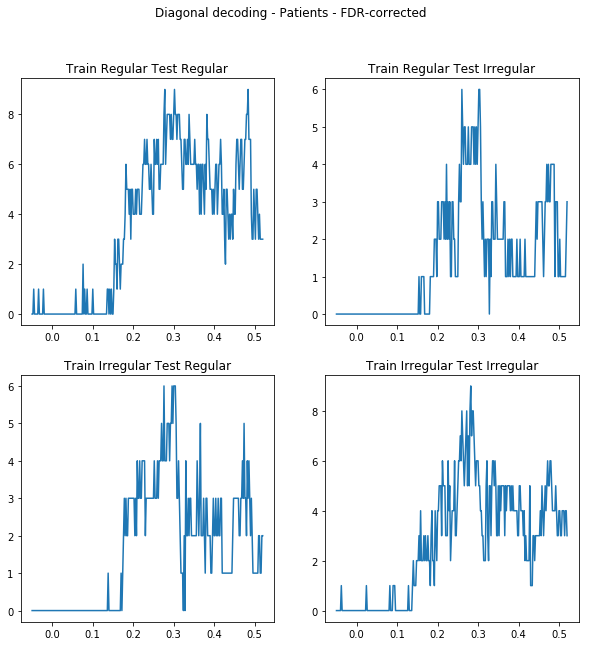

In [115]:

four_plots(timevec,subtitles,diag_sig_fdr_controls,'Controls')

four_plots(timevec,subtitles,diag_sig_fdr_patients,'Patients')

Uncorrected plots

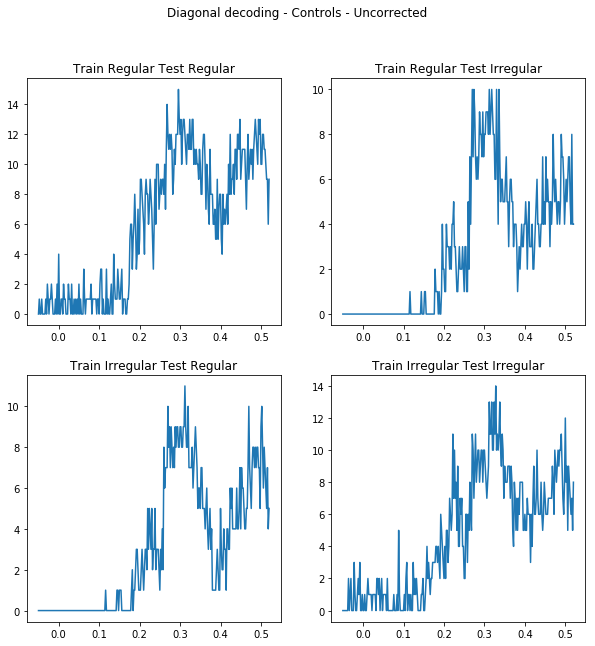

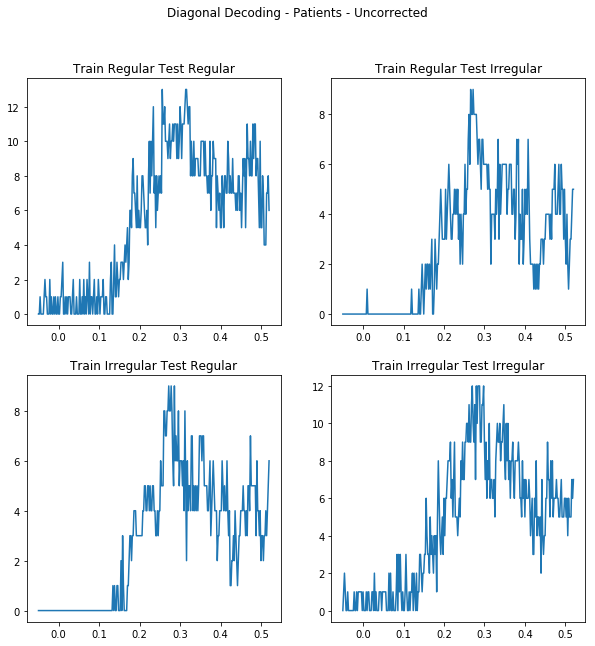

In [21]:
subtitles = ['Train Regular Test Regular',
            'Train Regular Test Irregular',
            'Train Irregular Test Regular',
            'Train Irregular Test Irregular']


plt.figure(figsize=(10,10))

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(timevec,diag_sig_unc_controls[i-1])
    plt.title(subtitles[i-1])
plt.suptitle('Diagonal decoding - Controls - Uncorrected')
plt.show()


plt.figure(figsize=(10,10))


for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(timevec,diag_sig_unc_patients[i-1])
    plt.title(subtitles[i-1])
plt.suptitle('Diagonal Decoding - Patients - Uncorrected')
plt.show()

Objective : find a reasonable min / max time window in which diagonal classification is significant for everyone. 

Problem - For up many subjects (controls AND patients), the calculated statistic is not significant. Why is this ? It may be an issue with the signal to noise ratio. 

In [66]:
from scipy.stats import wilcoxon

In [67]:
wilcoxon?

Signature: wilcoxon(x, y=None, zero_method='wilcox', correction=False)
Docstring:
Calculate the Wilcoxon signed-rank test.

The Wilcoxon signed-rank test tests the null hypothesis that two
related paired samples come from the same distribution. In particular,
it tests whether the distribution of the differences x - y is symmetric
about zero. It is a non-parametric version of the paired T-test.

Parameters
----------
x : array_like
    The first set of measurements.
y : array_like, optional
    The second set of measurements.  If `y` is not given, then the `x`
    array is considered to be the differences between the two sets of
    measurements.
zero_method : string, {"pratt", "wilcox", "zsplit"}, optional
    "pratt":
        Pratt treatment: includes zero-differences in the ranking process
        (more conservative)
    "wilcox":
        Wilcox treatment: discards all zero-differences
    "zsplit":
        Zero rank split: just like Pratt, but spliting the zero rank
        between 

Step 2 - Average duration of significant generalization

In the time window for which diagonal classification is significant for everyone, investigate every 100 ms whether there is temporal generalization. 

In [37]:
def offdiagonal_group(subjlist,statspath,timepoint):


    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([curmat[timepoint,:] for curmat in curpvals]) # extract a line from the matrix 

        diag_sig_fdr = []
        for curdiag in diag_pvals:
            H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
            diag_sig_fdr.append(H)

        return np.stack(diag_sig_fdr)

In [65]:
tp=0.300
tp_ind = 175
### Find the index corresponding to this timepoint 
print(timevec[tp_ind])

0.3


In [76]:
tp_ind2 = 225
### Find the index corresponding to this timepoint 
print(timevec[tp_ind2])

0.4


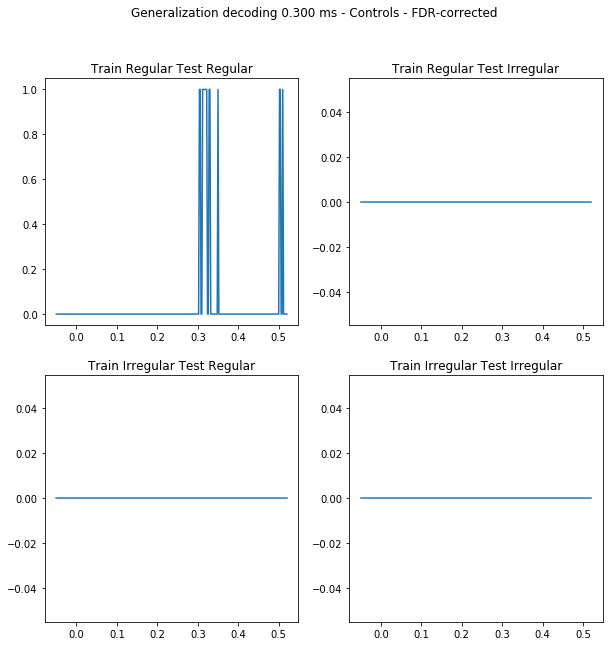

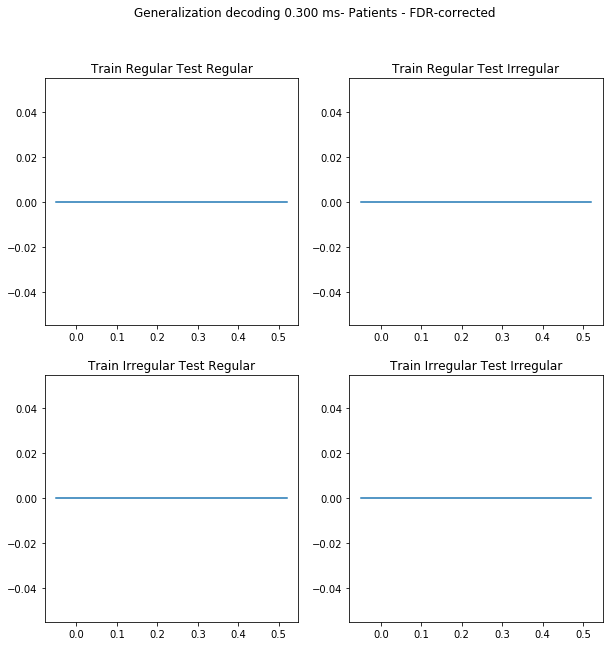

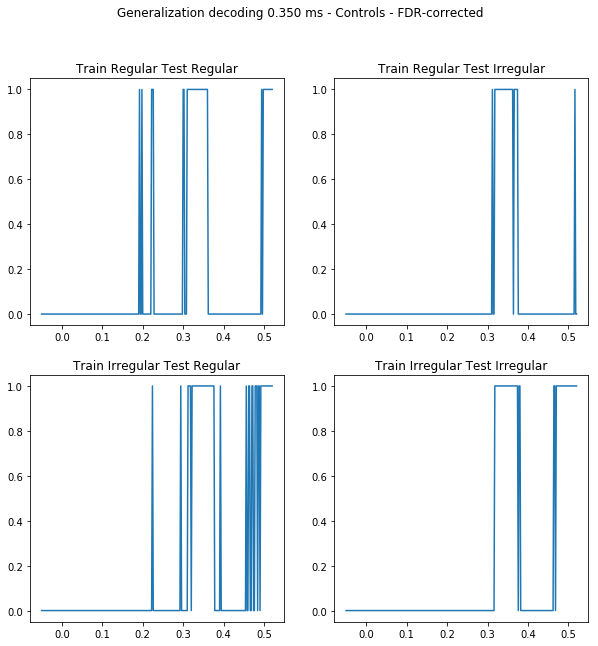

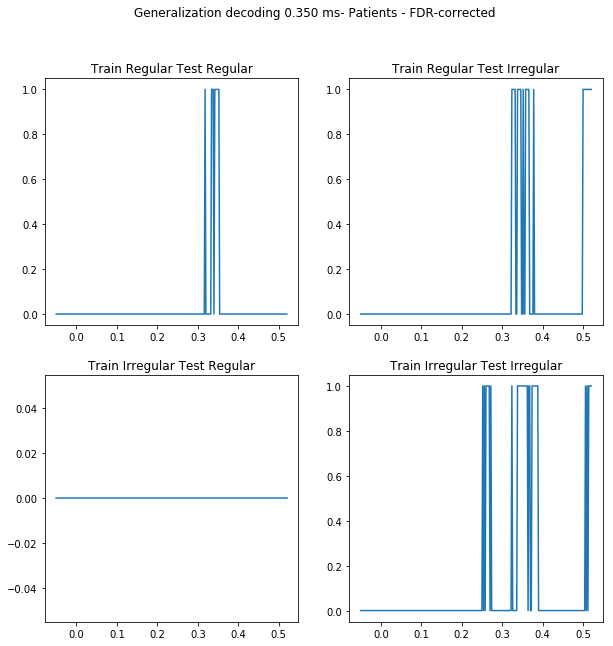

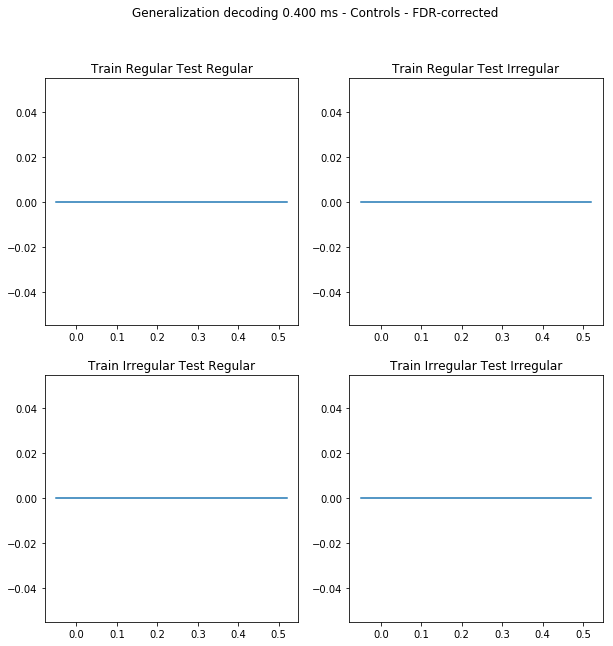

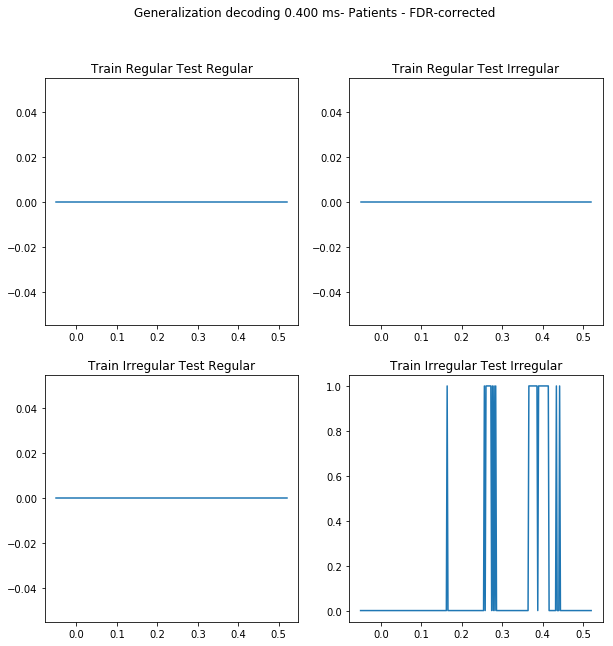

In [77]:
for curtp_ind in [175,200,225]:

    offdiag_sig_fdr_controls = offdiagonal_group(controls_id,statspath,curtp_ind)
    offdiag_sig_fdr_patients = offdiagonal_group(patients_id,statspath,curtp_ind)


    subtitles = ['Train Regular Test Regular',
                'Train Regular Test Irregular',
                'Train Irregular Test Regular',
                'Train Irregular Test Irregular']


    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,offdiag_sig_fdr_controls[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Generalization decoding %0.3f ms - Controls - FDR-corrected' % timevec[curtp_ind])
    plt.show()


    plt.figure(figsize=(10,10))


    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,offdiag_sig_fdr_patients[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Generalization decoding %0.3f ms- Patients - FDR-corrected' % timevec[curtp_ind])
    plt.show()


Step 3a - Across subjects statistics for controls 

In [78]:
for subj in controls_id:
    cursubj = os.path.join(statspath,subj)
    curpvals = np.load(cursubj)['proba'].mean(axis=1)
    

In [87]:
timepoints = np.array([ timevec[0],  timevec[-1],   timevec[0],  timevec[-1]])

In [91]:
curpvals.shape

(4, 2, 286, 286)

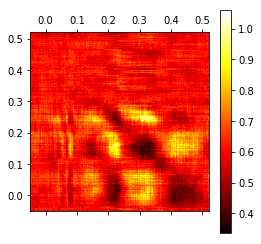

In [90]:
plt.matshow(-np.log10(curpvals[0][0]),extent=timepoints,cmap=plt.cm.hot)

plt.colorbar()

In [84]:
plt.imshow?

Step 3b - Across subjects statistics for patients 